In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import root
import pickle

from src.network_simulator import PoissonNetwork
from src.variational_bayes import VariationalBayes

In [65]:
enron_data = pd.read_csv('data/enron_emails/enron_tuples_filter.txt',
            sep=",", header=None, 
            dtype= {0:'int32', 1:'int32', 2:'int32'})
enron_data.columns = ['time', 'i', 'j']

# Convert 'time' column to datetime format
enron_data['time_date'] = pd.to_datetime(enron_data['time'], unit='s', 
                                         origin='unix')
# Calculate the difference in weeks
enron_data['days_since_1970'] = (enron_data['time_date'] - pd.to_datetime('1970-01-01')).dt.days
enron_data['weeks_since_1970'] = (enron_data['time_date'] - pd.to_datetime('1970-01-01')).dt.days // 7

enron_data['day_of_week'] = enron_data['time_date'].dt.dayofweek
# enron_data = enron_data.drop(columns=['time', 'time_date'])


In [94]:
enron_data[enron_data['time_date'] >= pd.to_datetime('2001-12-02')]

,time,i,j,time_date,days_since_1970,weeks_since_1970,day_of_week
12,1007938347,0,9,2001-12-09 22:52:27,11665,1666,6
13,1007952747,0,9,2001-12-10 02:52:27,11666,1666,0
14,1009816362,9,0,2001-12-31 16:32:42,11687,1669,0
15,1009830762,9,0,2001-12-31 20:32:42,11687,1669,0
16,1009906047,0,9,2002-01-01 17:27:27,11688,1669,1
...,...,...,...,...,...,...,...
34422,1022078617,134,148,2002-05-22 14:43:37,11829,1689,2
34423,1023984971,165,155,2002-06-13 16:16:11,11851,1693,3
34424,1023984971,165,162,2002-06-13 16:16:11,11851,1693,3
34425,1024681054,162,155,2002-06-21 17:37:34,11859,1694,4


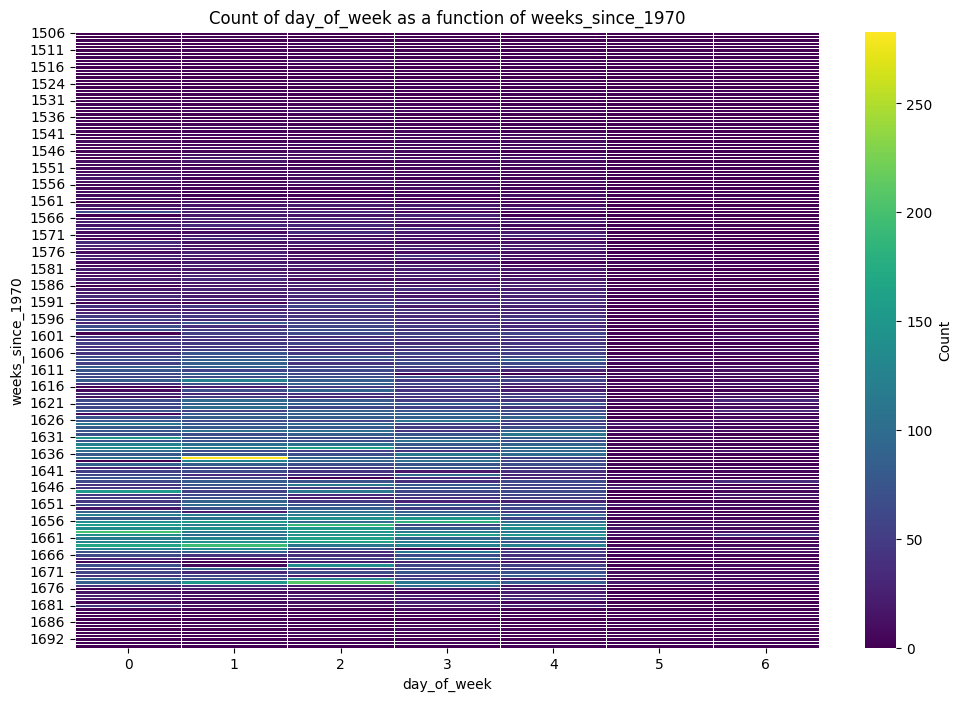

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pivot the DataFrame to create a 2D grid of counts
heatmap_data = enron_data.pivot_table(index='weeks_since_1970', columns='day_of_week', aggfunc='size', fill_value=0)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='viridis', linewidths=.5, annot=False, fmt='g', cbar_kws={'label': 'Count'})
plt.title('Count of day_of_week as a function of weeks_since_1970')
plt.show()

In [73]:
enron_data_plot = enron_data.drop(columns=['time', 'i', 'j', 'time_date', 'days_since_1970'])

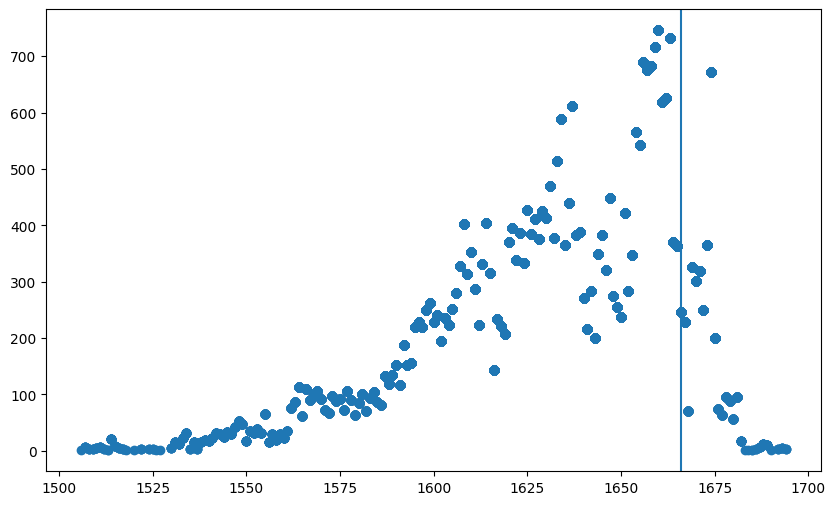

In [96]:
enron_data_plot['week_day_count'] = (
    enron_data_plot.groupby(['weeks_since_1970', 'day_of_week'])['day_of_week'].transform('count')
)
enron_data_plot['week_count'] = (
    enron_data_plot.groupby(['weeks_since_1970'])['weeks_since_1970'].transform('count')
)
plt.figure(figsize=(10, 6))
scatter = plt.scatter(enron_data_plot['weeks_since_1970'], 
                      enron_data_plot['week_count'])
plt.axvline(1666)
plt.show()

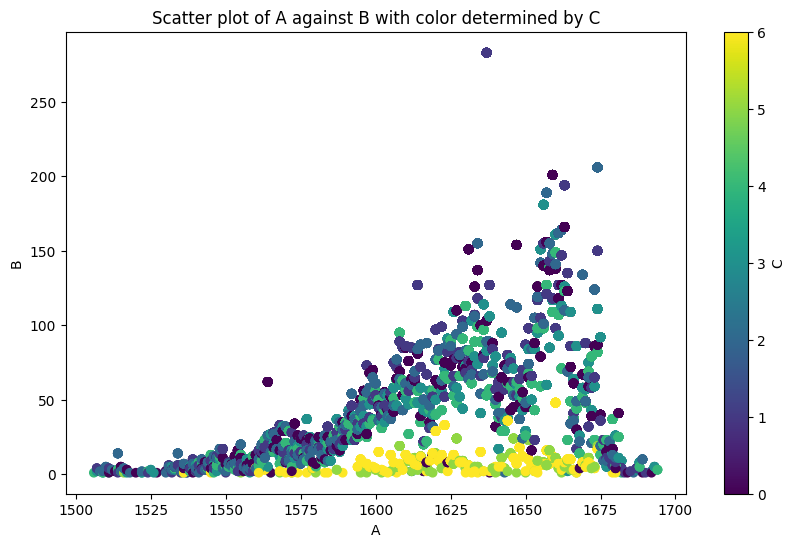

In [82]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(enron_data_plot['weeks_since_1970'], 
                      enron_data_plot['week_day_count'], 
                      c=enron_data_plot['day_of_week'], cmap='viridis', marker='o')
plt.colorbar(scatter, label='C')
plt.title('Scatter plot of A against B with color determined by C')
plt.xlabel('A')
plt.ylabel('B')
plt.show()

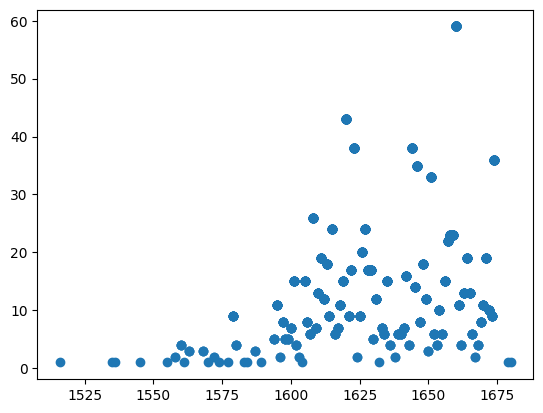

In [89]:
enron_data_weekend = (
    enron_data[enron_data.day_of_week.isin([5,6])].
    drop(columns=['time', 'i', 'j', 'time_date', 'day_of_week'])
)
enron_data_weekend['week_count'] = (
    enron_data_weekend.groupby(['weeks_since_1970'])['weeks_since_1970'].transform('count')
)
plt.scatter(enron_data_weekend['weeks_since_1970'], 
            enron_data_weekend['week_count'])

In [32]:
week_count = np.zeros((189,))
for i in range(189):
    week_count[i] = len(enron_data.loc[enron_data['week'] == i])

day_count = np.zeros((enron_data['day'].nunique(),))
for i in range(len(day_count)):
    day_count[i] = len(enron_data.loc[enron_data['day'] == i])

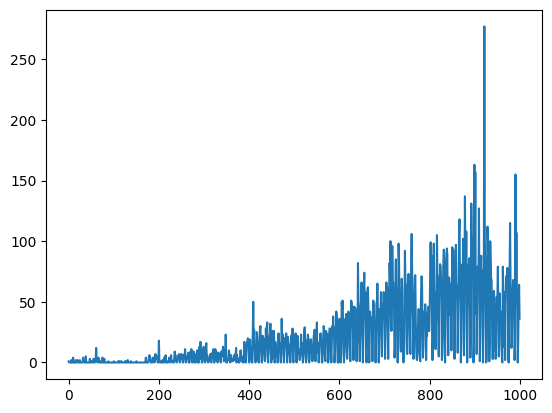

In [33]:
import matplotlib.pyplot as plt

plt.plot(np.arange(len(day_count)), day_count)

In [27]:
enron_data['time_date']

0       2001-05-25 17:22:29
1       2001-05-25 17:22:29
2       2001-05-25 17:22:29
3       2001-05-29 17:00:20
4       2001-05-29 17:35:06
                ...        
34422   2002-05-22 14:43:37
34423   2002-06-13 16:16:11
34424   2002-06-13 16:16:11
34425   2002-06-21 17:37:34
34426   2002-06-21 17:37:34
Name: time_date, Length: 34427, dtype: datetime64[ns]

In [24]:
enron_data['time'].max() < 1024099140

False

In [22]:
sum((enron_data['time'] > 956879940) * (enron_data['time'] < 1024099140))

31706